In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as M
from torchvision import transforms

from torch.utils.data import DataLoader

import numpy as np

from PIL import Image
import IPython.display as ipd

In [2]:
CUDA_VISIBLE_DEVICES = 5
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img + 1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            #nn.Sigmoid(),
        )
        
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], CH, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1) # N x C x size x size
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            self._block(z_dim+embed_size, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(0.2)
        )
    
    def forward(self, x, lables):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)

In [6]:
def gradient_penalty(critic, labels, real, fake, device='cpu'):
    bs, c, h, w = real.shape
    epsilon = torch.rand((bs, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    mixed_scores = critic(interpolated_images, labels)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    
    return gradient_penalty

In [7]:
def test():
    bs, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((bs, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((bs, z_dim, 1, 1))
    disc(gen(z))
    print('success')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 1e-4
BS = 64
IMG_SIZE = 64
CH = 1

Z_DIM = 100

EPOCHS = 10

N_CRIT = 5
#CLIP = 0.01

LAMBDA = 10
B1 = 0.0
B2 = 0.9

CLASSES = 10
GEN_EMB = 100

FEATURES_DISC, FEATURES_GEN = 64, 64

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CH)], [0.5 for _ in range(CH)]
        )
    ]
)

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
loader = DataLoader(dataset, batch_size=BS, shuffle=True)
gen = Generator(Z_DIM, CH, FEATURES_GEN, CLASSES, IMG_SIZE, GEN_EMB).to(device)
critic = Discriminator(CH, FEATURES_DISC, CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(B1, B2))
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=(B1, B2))
#criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()
print()

torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])


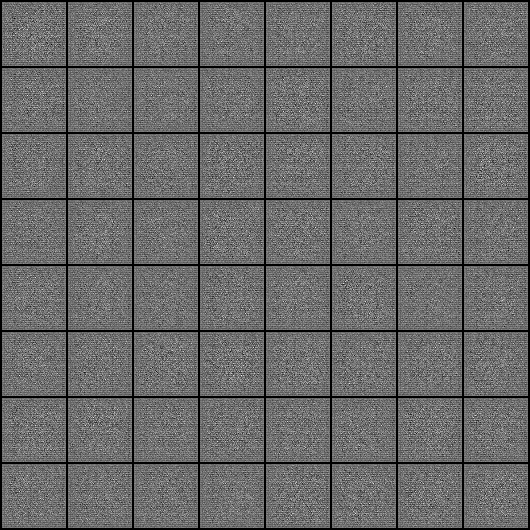

In [10]:
for epoch in range(EPOCHS):
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        labels = labels.to(device)
        
        for _ in range(N_CRIT):
            noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
            fake = gen(noise, labels)
        
            critic_real = critic(real, labels).reshape(-1) #N
            critic_fake = critic(fake, labels).reshape(-1)
            #RMSprop minimizes the loss so to maximize it we add a minus
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA * gp
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            
            '''for p in critic.parameters():
                p.data.clamp_(-CLIP, CLIP)'''
                        
        output = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        with torch.no_grad():
            fake = gen(noise, labels)

            img_grid_fake = torchvision.utils.make_grid(fake[:BS], normalize=True)
            img_grid_fake *= 255
            ipd.display(Image.fromarray(np.einsum('ijk->jki', img_grid_fake.cpu().numpy().astype(np.uint8))))
            break
            ipd.clear_output(wait=True)
    break

torch.Size([64, 100, 1, 1])
torch.Size([64, 200, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


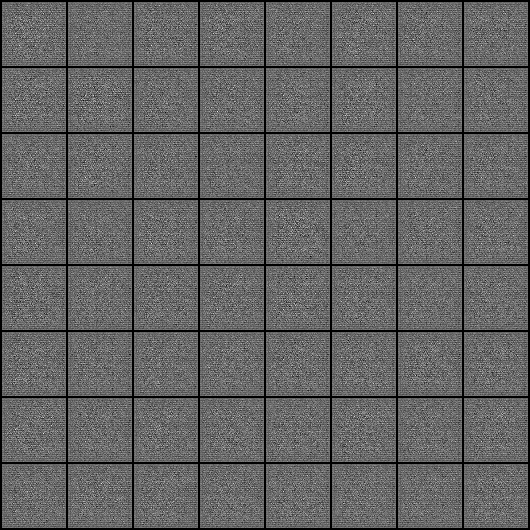

In [11]:
num = 0
noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
labels = torch.Tensor([num]*BS).type(torch.LongTensor).to(device)
with torch.no_grad():
    fake = gen(noise, labels)
    print(labels)
    img_grid_fake = torchvision.utils.make_grid(fake[:BS], normalize=True)
    img_grid_fake *= 255
    ipd.display(Image.fromarray(np.einsum('ijk->jki', img_grid_fake.cpu().numpy().astype(np.uint8))))